## Informe Final de Carrera - Data Science 

### Profundización de Procesamiento de Lenguaje Natural 


Por mi actualidad profesional tengo acceso de consulta y uso a grandes bases de texto (chatbots de atención, transcripción de llamadas de audio, instructivos de trabajo). 

Es por eso que cuando en las instancias del Proyecto 3 debimos ejercitar lo aprendido sobre aplicaciones elegí NLP. En la corrección de ese proyecto Daniela me sugirió material de Deep Learning como Tensorflow y Keras. 

En mi propia investigación realicé un curso online que ofrece Tensorflow en Udacity (gratuito) y varios artículos y discusiones sobre el tema. 

Puntualmente me resultó muy orgánico el siguiente: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794 ya que me permitía ver la diferencia entre las diferentes aproximaciones a los modelos, donde podían ser más útiles unos versus los demás y estrategias de medición que me ofrecieron mucha claridad. 

A continuación intentaré aplicar algunos de estos modelos de Deep Learning al dataset de reseñas de productos de Amazon, un poco en aplicación de lo visto en el curso al que hago referencia más arriba, aunque no de manera total porque hace mucho hincapié en predicción de sentimientos y creo que en la actualidad, particularmente desde la necesidad de digitalización masiva de procesos aministrativos, de atención y autogestión en la pandemia este es un enfoque secundario, y lo que más se requiere es eficiencia en soluciones IA de fácil armado. Es por eso que me resulta más interesante la óptica de clustering y poder predecir categorías (en este caso las estrellas de calificación) pensándolo en trasladar a temas de atención, consultas frecuentes, sinergia entre canales. También adapté código del artículo citado con mi proyecto anterior y algunos notebooks de clase. 

Considero que tengo mucho por aprender en este terreno, que hay mucha carencia de corpus en castellano (y multiliguales en general, es común ver esta limitación en las consultas en Stackoverflow de rusos, franceses, etc) lo cual compromete el accuracy respecto de la aplicación de los mismos códigos a datasets en inglés. Pero también entiendo que mi entrega no debe ser perfecta o final (si es que eso es posible en esta materia) sino mostrar mi razonamiento y entendimiento en el campo que elegí. 

# Parte 1 - Bag of Words con Tf-Idf

Esta presentación estará compuesta de dos partes, ambas mostrando una estrategia de clasificación multiclase de texto.

Omitiré el EDA del dataset ya que esa tarea fue hecha con profundidad en la entrega del Proyecto 3. Si usaré preprocesamiento de los datos de forma similar al Proyecto 3.

In [1]:
# Importo todas las librerías que utilizaré.
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [2]:
# A diferencia del proyecto anterior, previo a armar el dataset con Pandas, creo una lista diccionario leyendo el archivo Json.

lst_dics = []
with open('dataset_es_dev.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        lst_dics.append( json.loads(dic) )
## print the first one
lst_dics[0]

{'review_id': 'es_0417480',
 'product_id': 'product_es_0873923',
 'reviewer_id': 'reviewer_es_0672978',
 'stars': '1',
 'review_body': 'Malisimo, muy grande demasiado aparatoso y mal protector de pantalla',
 'review_title': 'Mala compra',
 'language': 'es',
 'product_category': 'wireless'}

In [3]:
# Creo el DataFrame con Pandas desde el diccionario.
dtf = pd.DataFrame(lst_dics)
# Filtro aquellas categorías con las que quiero trabajar. Excluyo la categoría de 3 estrellas ya que en el EDA del Proyecto 3 pude ver que estos valores neutrales
# dificultan en el modelo la predicción. 
dtf = dtf[ dtf["stars"].isin(['1','2','4','5']) ][["stars","review_body"]]
# Renombro las columnas para disminuir errores en la adaptación del código que usé como base
dtf = dtf.rename(columns={"stars":"y", "review_body":"text"})
# Imprimo algunas filas al azar para ver que sea lo que buscaba
dtf.sample(5)

,y,text
1771,2,"La radio FM no la escucho nítida, hace ruido d..."
4070,5,buen precio y buena calidad
1640,2,"No tiene potencia, al subir un poco la potenci..."
4379,5,"Tardó mas tiempo de la indicado en llegar, per..."
139,1,"Horrible!!! Muy malo, mal escrito, no lo recom..."


In [4]:
#Imprimo la descripción del dataset para asegurarme que no hay instancias con valores nulos, aunque ya conozco el dataset.
dtf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   y       4000 non-null   object
 1   text    4000 non-null   object
dtypes: object(2)
memory usage: 93.8+ KB


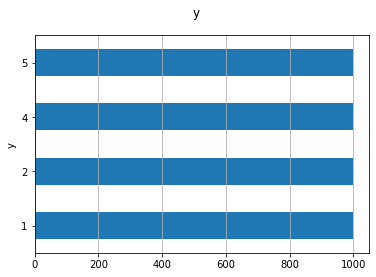

In [5]:
# Grafico la distribución de las categorías elegidas del dataset.

fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
dtf["y"].reset_index().groupby("y").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [6]:
# Se define una fórmula para limpiar el texto del dataset suprimiendo todos los caracteres especiales, llevando a minúsculas, tokenizando, stemizando y lemantizando


def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    #clean (convert to lowercase and remove punctuations and   
    #characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [7]:
#Defino la lista de stopwords
lst_stopwords = nltk.corpus.stopwords.words("spanish")
#lst_stopwords

In [8]:
# Aplico la formúla de regularización del texto y stopwords sobre el dataset. Creo una nueva columna con el texto limpio. Imprimo las primeras filas para validar.

dtf["text_clean"] = dtf["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dtf.head()

,y,text,text_clean
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",malisimo grande demasiado aparatoso mal protec...
1,1,No he recibido el pedido no la devolución,recibido pedido devolución
2,1,"Tengo que buscar otro sistema, este no funcion...",buscar sistema funciona bien abrazadera lleva ...
3,1,Utilicé las brocas de menor diámetro y se me d...,utilicé broca menor diámetro doblaron varias s...
4,1,No me gusta su olor a viejo y aspecto malo,gusta olor viejo aspecto malo


In [9]:
# Divido el dataset en test y entrenamiento
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)
## get target
y_train = dtf_train["y"].values
y_test = dtf_test["y"].values

## Bag of Words

El modelo construye un vocabulario desde un corpus de documentos (en este caso las reseñas) y cuenta cuántas veces la palabra aparece en cada documento. 

Cada palabra en el vocabulario se convierte en un feature y cada documento es representado por un vector con el mismo tamaño del vocabulario. 

Es por eso que el modelo puede presentar un problema de dimensionalidad. Cuantos más documentos a representar más crecerá la matriz. Por eso es importante el preprocesamiento de los datos (como el que hicimos en el paso anterior).

La frecuencia de los términos no suele ser la mejor representación, podemos encontrar términos con alta frecuencia pero bajo poder predictivo. Para esto usamos una variable de Bag of Words usando la frecuencia inversa, o Tf-Idf, donde el valor de una palabra crece proporcionalmente en cantidad, pero es inversamente proporcional a la frecuencia de la palabra en el corpus.

In [10]:
# Ingeniería de features: vectorizo el dataset mediante Tf-Idf, tomando tokens y bigrams. 

## Count (classic BoW)
#vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [11]:
corpus = dtf_train["text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [12]:
# En orden a reducir la disepersión de la matriz realizo una selección de features performando un test Chi que conservará solo aquellos features con un determinado
# valor de P (en este caso 0.95) 

from sklearn import feature_selection
from sklearn.feature_selection import chi2

y = dtf_train["y"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y): #Trata cada categoría como binaria, por ejemplo si es 5 le asignará el valor 1, y 0 respecto de las demas categorías (1, 2, 4)
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [13]:
corpus.shape

(2800,)

Text(0.5, 1.0, 'Ejemplo de Dispersión de la Matriz')

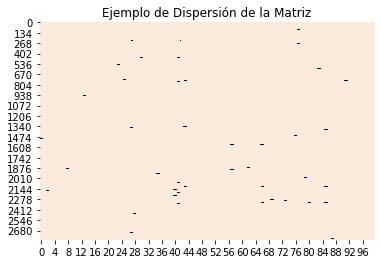

In [14]:
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Ejemplo de Dispersión de la Matriz')

In [15]:
#Imprimo algunos ejemplos de cada categoría 

for cat in np.unique(y):
    print("# {}:".format(cat))
    print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
    print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
    print(" ")

# 1:
  . selected features: 65
  . top features: malo,buena,dinero,devolución,recibido,nunca,me,devolver,buen,mierda
 
# 2:
  . selected features: 11
  . top features: rompen,buen,vibra,perfecto,devuelvo,rajado,parecía,correa,buen producto,do estrellas
 
# 4:
  . selected features: 29
  . top features: cumple,buena relación,relación,bien,único,única pega,precio,cumple expectativas,barata,bien aunque
 
# 5:
  . selected features: 33
  . top features: buen,buena calidad,perfecto,buen producto,encanta,buena,excelente,perfecta,genial,contenta
 


In [16]:
#Ahora re entrenamos el vectorizador sobre ese nuevo dataset refinado con el feature selection anterior
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

Text(0.5, 1.0, 'Ejemplo de dispersión de la Matriz')

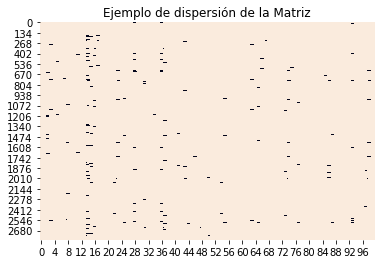

In [17]:
#Es posible ver que la matriz es menos dispersa.

sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Ejemplo de dispersión de la Matriz')

In [18]:
# Ya estando preprocesados los datos, llega el momento de aplicar un modelo de Machine Learning. Tal como en el proyecto 3 usaré el Naive Bayes Multinomial NB.
# Este modelos considera cada característica de forma independiente, calcula la probabilidad de cada categoría y luego predice la categoría con la probabilidad 
# más alta.

classifier = naive_bayes.MultinomialNB()

In [19]:
# La forma en que el artículo guía a aplicar el modelo es entrenar el modelo sobre la matriz vectorizada y probarlo en el conjunto de prueba transformado. 

# Creamos un Pipeline, que es una aplicación secuencial de una lista de transformaciones y un estimador final. Así transforma y predice datos de prueba en un solo dato.

## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Para medir la performance del modelo utilizaremos: 

* Accuracy: la fracción de predicciones que el modelo acertó.
* Matriz de confusión: una tabla de resumen que desglosa el número de predicciones correctas e incorrectas de cada clase.
* ROC: gráfico que ilustra la tasa de verdaderos positivos frente a la tasa de falsos positivos en varios valores de umbral. El área bajo la curva (AUC) indica la probabilidad de que el clasificador clasifique una observación positiva elegida aleatoriamente por encima de una observación negativa elegida aleatoriamente.
* Precisión: la fracción de instancias relevantes entre las instancias recuperadas.
* Recall: la fracción de la cantidad total de instancias relevantes que se recuperaron realmente.

Accuracy: 0.46
Auc: 0.75
Detail:
              precision    recall  f1-score   support

           1       0.59      0.46      0.52       308
           2       0.32      0.53      0.40       280
           4       0.44      0.35      0.39       311
           5       0.58      0.50      0.54       301

    accuracy                           0.46      1200
   macro avg       0.48      0.46      0.46      1200
weighted avg       0.49      0.46      0.46      1200



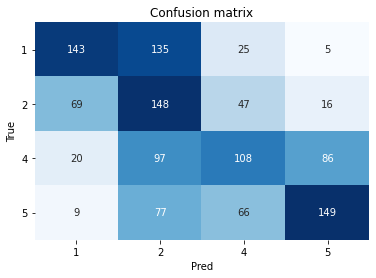

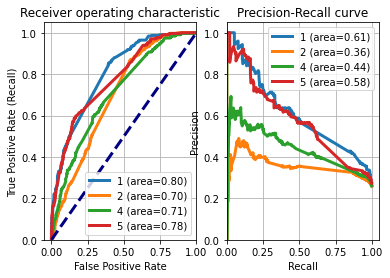

In [20]:
#Medición de performance del modelo.


from sklearn import metrics

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

Si comparo los resultados de este modelo con la corrida inicial realizada en el proyecto 3, se registra una mejora en Accuracy de casi 5 puntos, y sin modificar la estructura del dataset (en el proyecto 3 para mejorar el poder predictivo de los modelos generé una variable agrupadora (Promotor, Detractor) ya que como se puede ver en los gráficos la dificultad está en diferenciar las categorías cercanas a las extremas de estas.

Podemos tratar de entender por qué el modelo elige cada categoría mediante el uso de Lime Text Explainer.

Tomamos una observación aleatoria del conjunto de prueba y veremos qué predice el modelo y por qué. 

In [22]:
## select observation
i = 0
txt_instance = dtf_test["text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: 1 --> Pred: 1 | Prob: 0.55


# Parte 2 - Word Embedding

Bajo el nombre de Word Embedding se encuentran todas aquellas técnicas de aprendizaje donde las palabras de un vocabulario son convertidas a vectores de números reales. Esos vectores se calculan en base a la probabilidad de que cada palabra aparezca antes o después a otras. 

Las palabras del mismo contexto usualmente aparecen juntas en el corpus, entonces estarán cerca en el espacio vectorial también. 

En este ejercicio usaré Word2Vec (Google 2013). También existen GloVe o Fast Text de Facebook. Las librerías necesarias para W2V las importaré a través de Gensim.

In [23]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [24]:
# Usaré un modelo pre entrenado que es el de Google News. Si bien investigué para cargar algún modelo no multilenguaje como este y específico de español
# encontré opciones cuyo peso de descarga era muy alto (más adecuado para trabajar con Colabs) y no estaban dentro del catálogo de Gensim. 

nlp = gensim_api.load("word2vec-google-news-300")

In [25]:
# Antes de entrenar el modelo el corpus debe ser transformado en una lista de N-gramas, bigrams y trigrams.


corpus = dtf_train["text_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [26]:
## Entrenamiento w2v
#Hiperparámetros: 

#Size: el tamaño de los vectores de las palabras
#Window: Distancia máxima entre la palabra actual y la predicha dentro de una oración
#Sg: es el algoritmo de entrenamiento, en este caso Skip-gram que desde una palabra única predice el contexto (también existe Continuos Bag of Word, que va del contexto a la palabra).


nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=5, min_count=1, sg=1, iter=30)

In [27]:
#Ya teniendo el modelo de incrustación podemos tomar cualquier palabra y convertirla en un vector.

word = "calidad"
nlp[word].shape

<ipython-input-27-93483a50eca7>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  nlp[word].shape


(300,)

<ipython-input-28-4dd10e4e1919>:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  nlp.most_similar(word, topn=20)]
<ipython-input-28-4dd10e4e1919>:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = nlp[tot_words]
C:\Users\cti22275\Miniconda3\envs\datascience\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


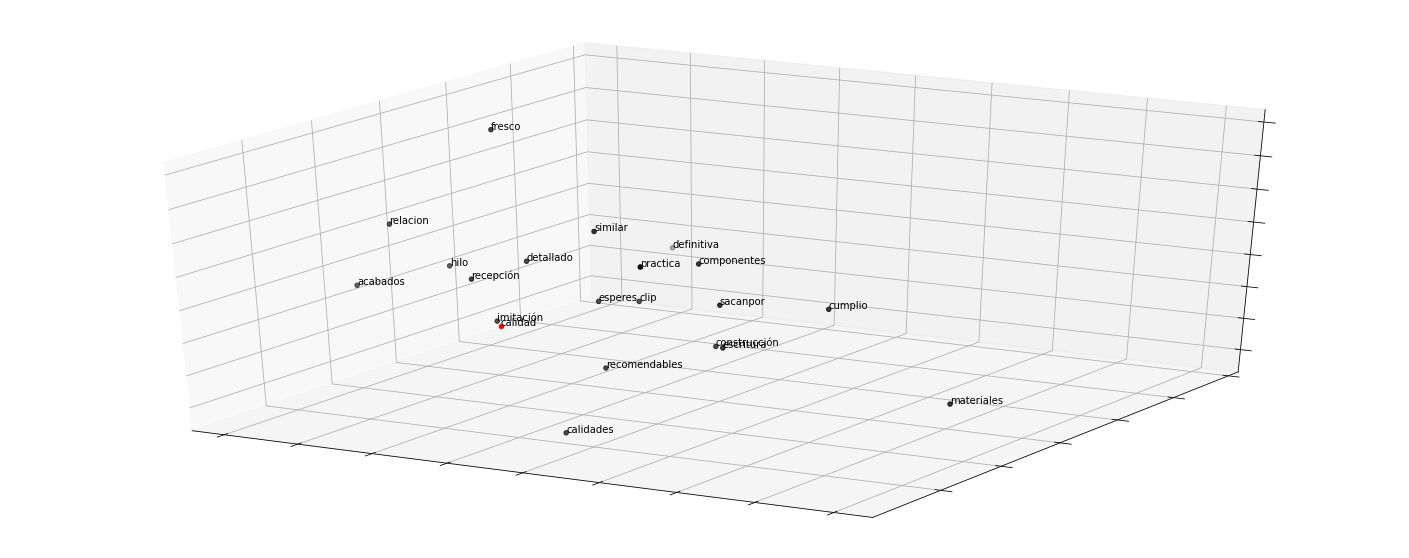

In [28]:
#También es posible visualizar una palabra y su contexto en un espacio 3D más pequeño, aplicando una reducción de dimensionalidad 
#(TSNE, t-distributed Stochastic Neighbor Embedding)+PCA

word = "calidad"
fig = plt.figure(figsize=(25,10))

## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X = nlp[tot_words]

## pca para reducir dimensionalidad from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

## crear dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1

## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)
    
plt.show()

¿Cómo el Word Embedding es útil para predecir las categorías que necesitamos?

Estos vectores de palabras pueden usarse en una red neuronal como pesos. 

## Tensorflow / Keras

En estos tres primeros pasos realizaremos un feature engineneering transformando el corpus preprocesado como una lista de n-gramas en una lista de secuencias. 

In [29]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index

## crear secuencia usando tensorflow / keras 
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")


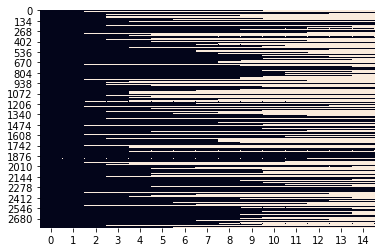

In [30]:
#Cada texto en el corpus ahora es un ID de secuencia con una longitud 15. O sea si un token tiene una longitud de 10 caracteres, la secuencia estará compuesta por 10
#IDs de secuencia y 5 ceros (ya que el ID para aquellas palabras que no están en el corpus es 1) 

sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [31]:
#Podemos imprimir como un texto de set de entrenamiento ha sido transformado en una secuencia 

i = 0

## lista de textos 
len_txt = len(dtf_train["text_clean"].iloc[i].split())
print("from: ", dtf_train["text_clean"].iloc[i], "| len:", len_txt)

## secuencia de Ids de tokens: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  buen producto olor suave | len: 4
to:  [ 11   4 301 360   0   0   0   0   0   0   0   0   0   0   0] | len: 15
vocabulary:  {'NaN': 1, 'bien': 2, 'calidad': 3, 'producto': 4, 'si': 5} ... (padding element, 0)


In [32]:
#Volvemos a preprocesar y realizar una ingeniería de features.

corpus = dtf_test["text_clean"]

## crear una lista de n-gramas
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detectar bigrams y trigrams comunes 
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

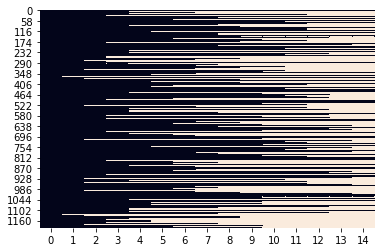

In [33]:
#Se puede observar una distribución más homogénea de las secuencias luego de la ingenienría de features.

sns.heatmap(X_test==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [34]:
# Una vez que tenemos nuestro X_train y X_test, debemos armar la matriz de embedding que usaremos como weight matrix en la red neuronal clasificadora. 

## Comenzar la matriz (dimensión del vocabulary x tamaño del vector) con todos los ceros
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## actualizar la fila con vector
    try:
        embeddings[idx] =  nlp[word]
    ## si la palabra no está en el modelo, la saltea completándola con ceros.
    except:
        pass

<ipython-input-34-1c6332a434da>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings[idx] =  nlp[word]


In [35]:
#Podemos navegar a traves de las palabras y ver el vector y el id.

word = "devuelto"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 233 |idx
embeddings[idx]: (300,) |vector


## Modelo de Deep Learning

La Embedding Matrix será la primer capa de la red neuronal, por otro lado cada Id en la secuencia de entrada será usada como índice para acceder a la matriz de incrustación (Embedding Matrix). 

La salida de esta capa será una matriz 2D con un vector por cada id de palabra en la secuencia de ingreso (Sequence length x Vector Size). 

Tendrá además dos capas de LSTM Bidireccional, que ordenará las palabras en secuencias en dos direcciones. 

Finalmente tendrá dos capas densas que podrán predecir la probabilidad de cada categoría.

In [36]:
## Capa de Attention: captura el peso de cada instancia y genera un explicador. Busca comprender qué partes de un texto son realmente relevantes. 
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(7, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 300)      2423400     input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 300, 15)      0           embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 300, 15)      240         permute[0][0]                    
______________________________________________________________________________________________

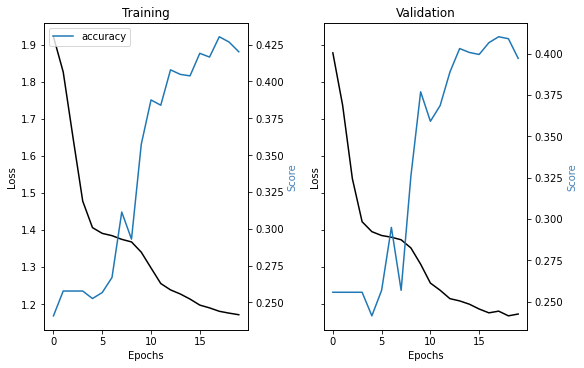

In [37]:
# Entrenamos el modelo y chequeamos la performance en un subset del set de entrenamiento.

## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=20, shuffle=True, verbose=0, 
                     validation_split=0.3)
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, constrained_layout = True, figsize = (8, 5))
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

Es posible ver que a medida que avanzan cada Epochs (que son ciclos completos de entrenamiento en una red neuronal) disminuye la pérdida (Loss) y mejora la exactitud en el dataset de entrenamiento. En el dataset de Prueba (validation) la pérdida (Loss) y la exactitud (Accuracy) arriban a valores similares. 

La aplicación de los modelos fue sin optimización de hiperparámetros que seguramente mejorarían esos resultados.

In [38]:
dtf_test.shape

(1200, 3)

True: 1 --> Pred: 1 | Prob: 0.55
[['solo', 'recibí', '1', 'de', 'los', '3', 'cables', 'que', 'ofertan']]


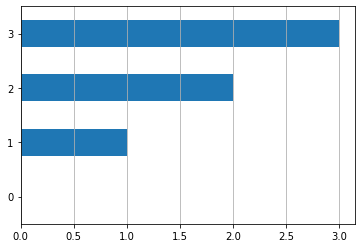

Texto destacado


In [39]:
# Imprimo una observación del tratamiento que da el modelo a alguna frase random, qué categorías consideró probables, cuál era el valor real (True) y la predicción. 

# Además si el peso (weigth) de algunos de los vectores es mayor a cero aplicará una clase de HTML para destacar los textos que el modelo consideró más relevante.

from IPython.core.display import display, HTML 


## select observation
i = 0
txt_instance = dtf_test["text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))

## show explanation
### 1. preprocess input
lst_corpus = []
for string in [re.sub(r'[^\w\s]','', txt_instance.lower().strip())]:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
print(lst_corpus)
X_instance = kprocessing.sequence.pad_sequences(
              tokenizer.texts_to_sequences(corpus), maxlen=15, 
              padding="post", truncating="post")
### 2. get attention weights
layer = [layer for layer in model.layers if "attention" in 
         layer.name][0]
func = K.function([model.input], [layer.output])
weights = func(X_instance)[0]
weights = np.mean(weights, axis=2).flatten()
### 3. rescale weights, remove null vector, map word-weight
weights = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(weights).reshape(-1,1)).reshape(-1)
weights = [weights[n] for n,idx in enumerate(X_instance[0]) if idx 
           != 0]
dic_word_weigth = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
### 4. barplot
if len(dic_word_weigth) > 0:
    dtf = pd.DataFrame.from_dict(dic_word_weigth, orient='index', 
                                columns=["score"])
    dtf.sort_values(by="score", 
           ascending=True).tail().plot(kind="barh", 
           legend=False).grid(axis='x')
    plt.show()
else:
    print("--- No word recognized ---")
### 5. produce html visualization
text = []
for word in lst_corpus[0]:
    weight = dic_word_weigth.get(word)
    if weight is not None:
         text.append('<span style="background-color:rgba(100,149,237)' + str(weight) + ');">' + word + '</span></b>')
    else:
         text.append(word)
text = ' '.join(text)
### 6. visualize on notebook
print("\033[1m"+"Texto destacado")
display(HTML(text))


In [40]:
from sklearn import metrics

## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

In [41]:
predicted_prob = pd.DataFrame(predicted_prob)

predicted_prob.shape

(1200, 7)

In [42]:
predicted = pd.DataFrame(predicted)

predicted.shape

(1200, 1)

Accuracy: 0.43
Auc: 0.75
Detail:
              precision    recall  f1-score   support

           1       0.60      0.49      0.54       308
           2       0.38      0.35      0.36       280
           4       0.37      0.26      0.31       311
           5       0.40      0.62      0.49       301

    accuracy                           0.43      1200
   macro avg       0.44      0.43      0.42      1200
weighted avg       0.44      0.43      0.42      1200



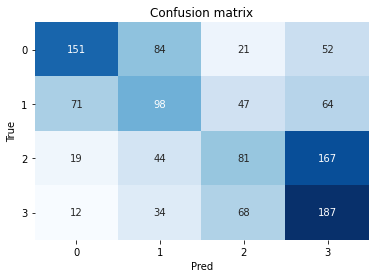

In [43]:
#Por último medimos la Exactitud, Precisión y Recall del modelo. También observamos la Matriz de confusión. 

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)

try:
    auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
except ValueError:
    pass

print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=predicted_prob, 
       yticklabels=predicted_prob, title="Confusion matrix")
plt.yticks(rotation=0)

    
plt.show()

En el artículo que usé como inspiración y guía hay un modelo extra, BERT, que se presenta ya como un Modelo de Lenguaje y supera algunas de las limitaciones de los modelos presentados (desambiguación polisémica o de una palabra con diferentes significados. 

El campo de análisis de lenguaje y NLP es el que me resultó más interesante y seguramente el que seguiré profundizando y aprendiendo. 

Carolina Degiorgio